## LIBRARIES

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
%matplotlib inline 
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
import re
import string
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import numpy as np
import itertools

## DATA PREPERATION

In [2]:
# Read CSV Dataset Files
fakedf = pd.read_csv('./dataset/Fake.csv')
truedf = pd.read_csv('./dataset/True.csv')

# Create 'target' for fake and real news
fakedf['target'] = 'fake'
truedf['target'] = 'true'

# Concatenate both DataFrames into a single dataset containing both real and fake news 
NewsData = pd.concat([fakedf, truedf]).reset_index(drop = True)

# Shuffle the data to prevent overfitting and dataset memorization
NewsData = shuffle(NewsData)
NewsData = NewsData.reset_index(drop=True)

#  Adjust columns in NewsData
NewsData['news']=NewsData['title']+NewsData['text']
NewsData=NewsData.drop(['title', 'text'], axis=1)
NewsData['date'].value_counts()

# Make Dataset Smaller for Faster Run Time
NewsData_S  = NewsData[:500]

# Place independent features in X variable 
X = NewsData_S.drop('target',axis =1)

# Place 'target' values (True or False) in y variable
y = NewsData_S['target']

# Create a copy of the adjusted dataset
NewsData_Adjusted = NewsData_S.copy()

# EXPLORATORY DATA ANALYSIS 

## Exploring word count of real and fake news

In [3]:
# Compute word-count for each news article

NewsData['word_count'] = NewsData['news'].apply(lambda x: len(str(x).split()))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


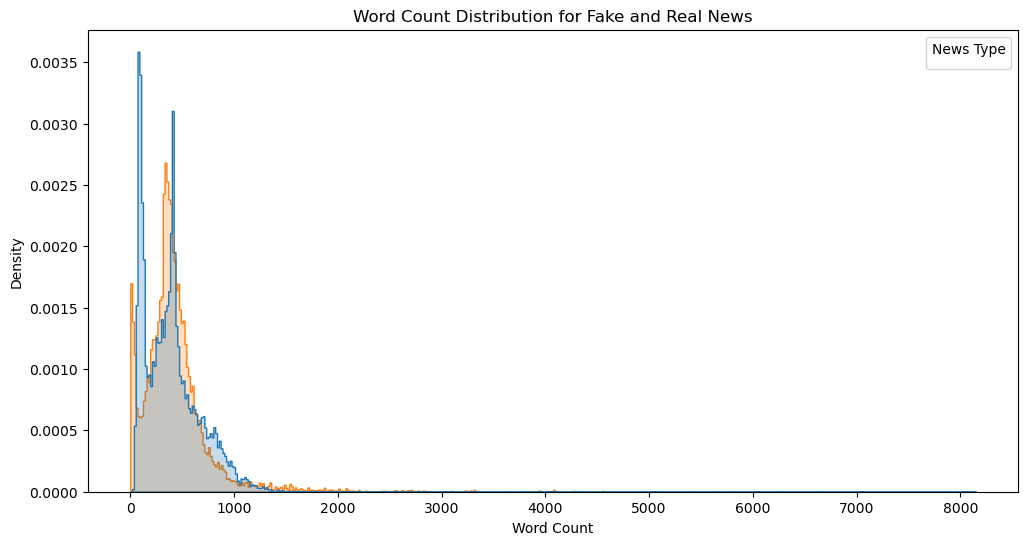

In [14]:
# Plotting word count between real and fake News
plt.figure(figsize=(12, 6))
sns.histplot(NewsData, x='word_count', hue='target', element='step', stat='density', common_norm=False)
plt.title('Word Count Distribution for Fake and Real News')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend(title='News Type')
plt.show()

## Exploring title length of real and fake news

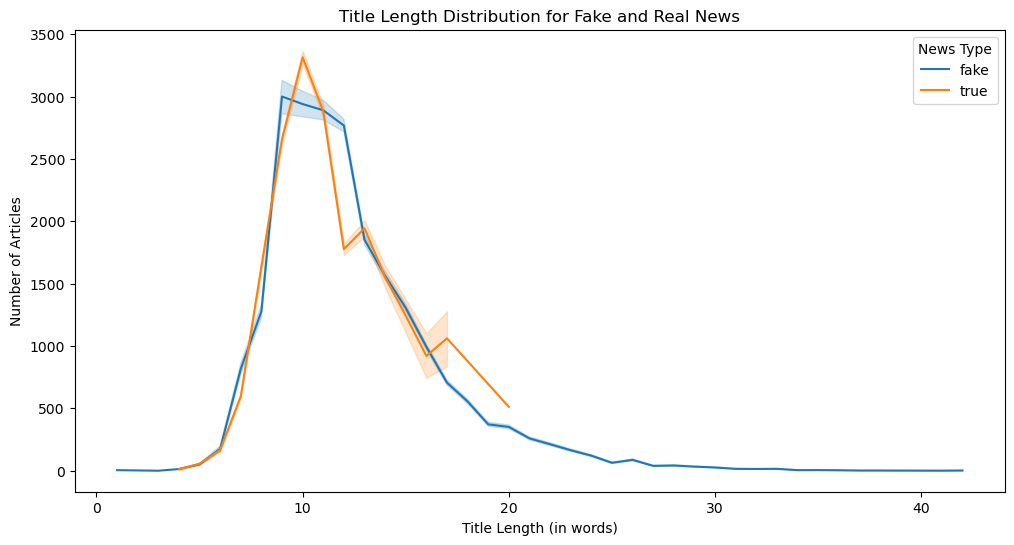

In [21]:
fakedf['title_length'] = fakedf['title'].apply(lambda x: len(str(x).split()))
truedf['title_length'] = truedf['title'].apply(lambda x: len(str(x).split()))

# Combine the dataframes for visualization
combined_df = pd.concat([fakedf, truedf])

# Sort by title length for a smoother line graph
combined_df = combined_df.sort_values(by="title_length").reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='title_length', y=combined_df.groupby('title_length').cumcount(), hue='target')
plt.title('Title Length Distribution for Fake and Real News')
plt.xlabel('Title Length (in words)')
plt.ylabel('Number of Articles')
plt.legend(title='News Type')
plt.show()

## Exploring punctuation usage of real and fake news

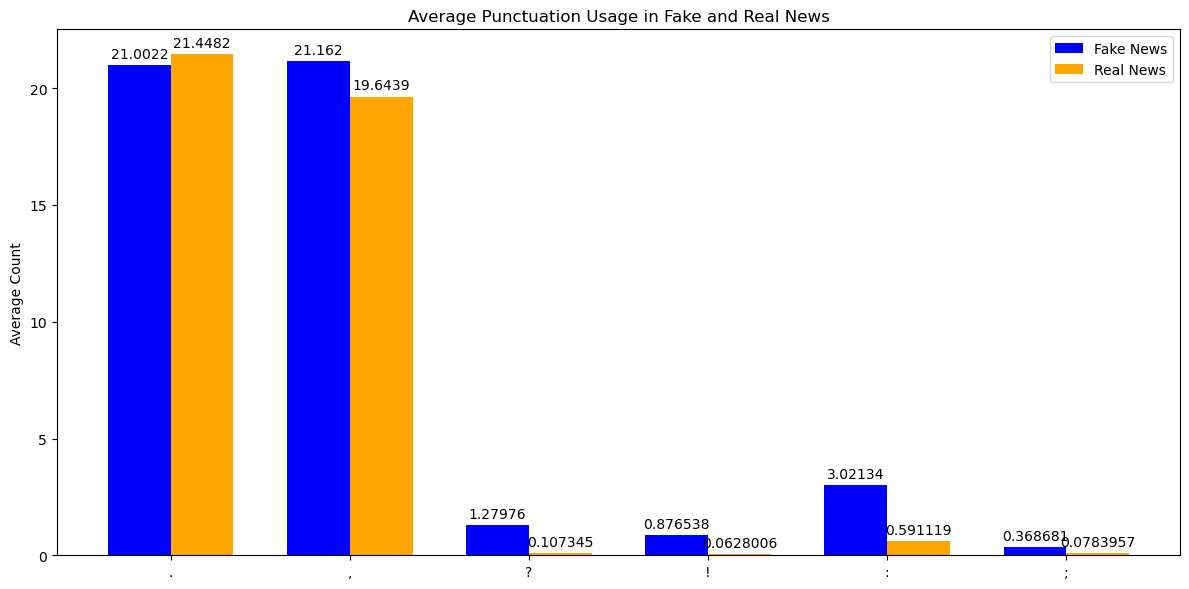

In [19]:
def count_specific_punct(text, punct):
    return text.count(punct)

punctuation_list = ['.', ',', '?', '!', ':', ';']

for punct in punctuation_list:
    NewsData[punct] = NewsData['news'].apply(lambda x: count_specific_punct(x, punct))
    
mean_punctuation_counts = NewsData.groupby('target')[punctuation_list].mean().transpose()

labels = mean_punctuation_counts.index
fake_counts = mean_punctuation_counts['fake']
real_counts = mean_punctuation_counts['true']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, fake_counts, width, label='Fake News', color='blue')
rects2 = ax.bar(x + width/2, real_counts, width, label='Real News', color='orange')

ax.set_ylabel('Average Count')
ax.set_title('Average Punctuation Usage in Fake and Real News')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()




In [23]:
## Explore Lexical Diversity

## TOKENIZATION AND TEXT PREPROCESSING

In [4]:
port_S = PorterStemmer()
array_= []

for i in range(0, len(NewsData_Adjusted)):
      text_adj = re.sub('[^a-zA-Z]', ' ', NewsData_Adjusted['news'][i])
      text_adj = re.sub('https?://\S+|www\.\S+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('<.*?>+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('[%s]' % re.escape(string.punctuation), '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\n', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\w*\d\w*', '', NewsData_Adjusted['news'][i])
      text_adj = text_adj.lower()
      text_adj = text_adj.split()
      text_adj = [port_S.stem(word) for word in text_adj if not word in stopwords.words('english')]
      text_adj = ' '.join(text_adj)
      array_.append(text_adj)



## BAG WORDS AND COUNT VECTORS

In [5]:
cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(array_).toarray()
X.shape 
y =NewsData_Adjusted['target']

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)

In [7]:
count_df = pd.DataFrame(X_train,columns = cv.get_feature_names_out())

In [8]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    
    # Evaluation of Results
    acc_score = accuracy_score(y_test, pred)
    percent_conv = acc_score * 100
    print("Acc: %0.2f%%" % percent_conv)
    
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()

# MultinomialNB

Acc: 97.00%


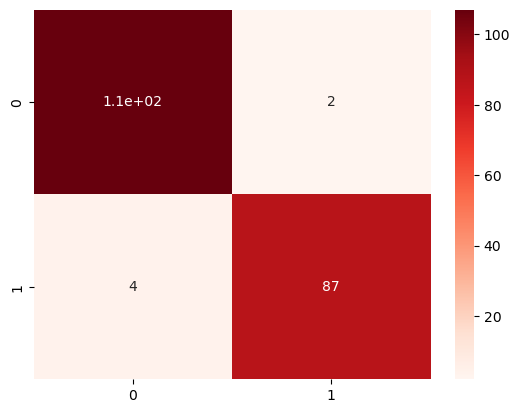

In [9]:
MultinomialNB_classifier = MultinomialNB()
evaluate_classifier(MultinomialNB_classifier, X_train, y_train, X_test, y_test, heatmap_color='Reds')

# kNN Classification

Acc: 61.50%


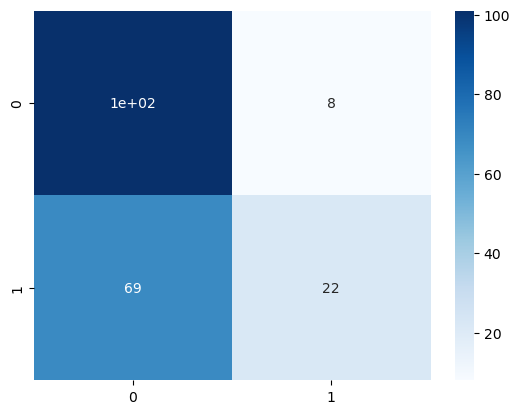

In [10]:
knn_classifier = KNeighborsClassifier()
evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues')

# Logistic Regression

Acc: 94.00%


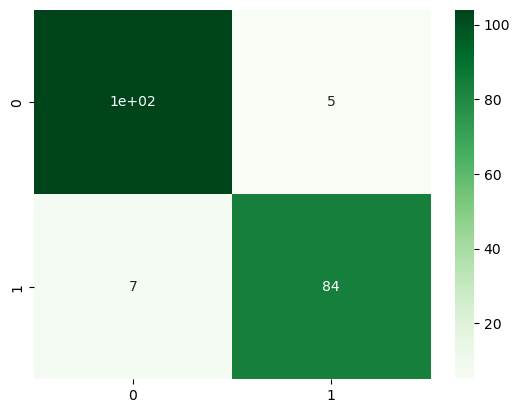

In [11]:
logreg_classifier = LogisticRegression()
evaluate_classifier(logreg_classifier, X_train, y_train, X_test, y_test, heatmap_color = "Greens")

# Random Forest Classifier

Acc: 99.00%


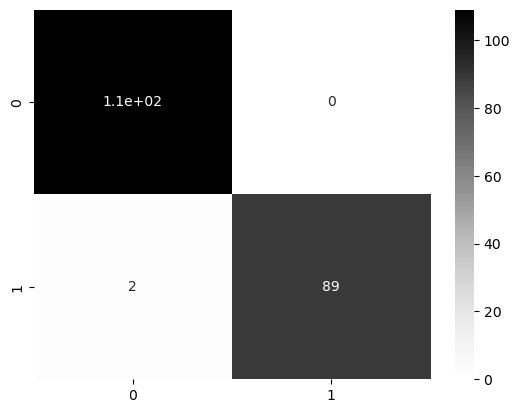

In [12]:
rfc = RandomForestClassifier(n_estimators = 600, bootstrap = True, random_state=8)
evaluate_classifier(rfc, X_train, y_train, X_test, y_test, heatmap_color = "Greys")

# Passive Agressive Classifier

Acc: 94.00%


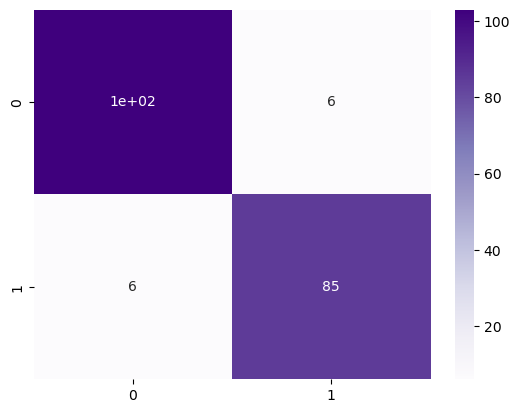

In [13]:
pac = PassiveAggressiveClassifier()
evaluate_classifier(pac, X_train, y_train, X_test, y_test, heatmap_color = "Purples")

# REFERENCES

## [1] Bisaillon, C. (n.d.). Fake and Real News Dataset. Retrieved May 7, 2023, from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
